# TB User behaviors analysis

数据来源：<https://tianchi.aliyun.com/competition/entrance/532059>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

In [2]:
sns.set_theme() 
sns.set_context("notebook") 

In [3]:
data = pd.read_csv("user_action.csv")
data.head(5)

,user_id,item_id,behavior_type,item_category,time
0,98047837,232431562,1,4245,2014-12-06 02
1,97726136,383583590,1,5894,2014-12-09 20
2,98607707,64749712,1,2883,2014-12-18 11
3,98662432,320593836,1,6562,2014-12-06 10
4,98145908,290208520,1,13926,2014-12-16 21


字段	字段说明	提取说明  
user_id	用户标识	抽样&字段脱敏  
item_id	商品标识	字段脱敏  
behavior_type	用户对商品的行为类型	包括浏览、收藏、加购物车、购买，对应取值分别是1、2、3、4。  
item_category	商品分类标识	字段脱敏  
time	行为时间	精确到小时级别  

In [4]:
data["date"] = data["time"].map(lambda x: x.split()[0])
data["hour"] = data["time"].map(lambda x: x.split()[1])
data.drop(columns='time')
data.head(5)


,user_id,item_id,behavior_type,item_category,time,date,hour
0,98047837,232431562,1,4245,2014-12-06 02,2014-12-06,02
1,97726136,383583590,1,5894,2014-12-09 20,2014-12-09,20
2,98607707,64749712,1,2883,2014-12-18 11,2014-12-18,11
3,98662432,320593836,1,6562,2014-12-06 10,2014-12-06,10
4,98145908,290208520,1,13926,2014-12-16 21,2014-12-16,21


In [5]:
data["date"] = pd.to_datetime(data["date"])
data["hour"] = data["hour"].astype("int64")  # type: ignore[assignment]  # pylint: disable=no-member  # mypy
data.head(5)

,user_id,item_id,behavior_type,item_category,time,date,hour
0,98047837,232431562,1,4245,2014-12-06 02,2014-12-06,2
1,97726136,383583590,1,5894,2014-12-09 20,2014-12-09,20
2,98607707,64749712,1,2883,2014-12-18 11,2014-12-18,11
3,98662432,320593836,1,6562,2014-12-06 10,2014-12-06,10
4,98145908,290208520,1,13926,2014-12-16 21,2014-12-16,21


In [6]:
data.isnull().sum()

user_id          0
item_id          0
behavior_type    0
item_category    0
time             0
date             0
hour             0
dtype: int64

In [45]:
# 计算访问频次
visit_cnt = data.groupby(by=["user_id"]).size()

# 转化率
trans_rate = (
    data.groupby(by=["user_id"])["behavior_type"].agg(lambda x: x[x==4].size)
    / visit_cnt
)

# 计算生命周期
life_cycle = data.groupby(by=["user_id"])["date"].agg(lambda x: max(x) - min(x))

# 计算RFM
rfm = data.groupby(by=["user_id"]).agg(
    {
        "date": lambda x: data['date'].max() - max(x),
        # 计算每个用户的最后一次访问日期与数据集中的最后一次访问日期之间的天数差，作为用户的生命周期
        "behavior_type": lambda x: x[x == 4].sum(),
        # 计算每个用户的购买次数
    }
)

print(visit_cnt, trans_rate, life_cycle, rfm)

user_id
4913         1742
6118          117
7528          214
7591          859
12645         268
             ... 
142376113     322
142412247     335
142430177    1481
142450275    6819
142455899    1351
Length: 10000, dtype: int64 user_id
4913         0.003444
6118         0.008547
7528         0.028037
7591         0.024447
12645        0.029851
               ...   
142376113    0.003106
142412247    0.035821
142430177    0.003376
142450275    0.005866
142455899    0.009623
Length: 10000, dtype: float64 user_id
4913        30 days
6118        29 days
7528        23 days
7591        30 days
12645       30 days
              ...  
142376113   25 days
142412247   29 days
142430177   30 days
142450275   30 days
142455899   25 days
Name: date, Length: 10000, dtype: timedelta64[ns]             date  behavior_type
user_id                        
4913      0 days             24
6118      0 days              4
7528      4 days             24
7591      0 days             84
12645     0 days

In [39]:
user_feat = pd.DataFrame(
    {
        "user_id": visit_cnt.index,
        "trans_rate": trans_rate.values,
        "visit_cnt": visit_cnt.values,
        "life_cycle": life_cycle.values,
        "R": rfm["date"].values,
        "F": rfm["behavior_type"].values,
    }
)

user_feat.head(10)

,user_id,trans_rate,visit_cnt,life_cycle,R,F
0,4913,0.003444,1742,30 days,0 days,24
1,6118,0.008547,117,29 days,0 days,4
2,7528,0.028037,214,23 days,4 days,24
3,7591,0.024447,859,30 days,0 days,84
4,12645,0.029851,268,30 days,0 days,32
5,45368,0.000000,36,15 days,14 days,0
6,54056,0.052632,38,19 days,11 days,8
7,63348,0.003984,251,23 days,2 days,4
8,79824,0.019608,663,30 days,0 days,52
9,88930,0.014339,1604,30 days,0 days,92


In [9]:
user_feat.dtypes

user_id                 int64
trans_rate            float64
visit_cnt               int64
life_cycle    timedelta64[ns]
R             timedelta64[ns]
F                       int64
dtype: object

In [10]:
user_feat[user_feat.isnull().any(axis=1)]

,user_id,trans_rate,visit_cnt,life_cycle,R,F


In [40]:
user_feat["visit_cnt"] = user_feat["visit_cnt"].astype("object")
user_feat["trans_rate"] = user_feat["trans_rate"].astype("object")
user_feat["life_cycle"] = user_feat["life_cycle"].map(lambda x: x.days).astype("object")
user_feat["R"] = user_feat["R"].map(lambda x: x.days).astype("object")
user_feat["F"] = user_feat["F"].astype("object")
user_feat.dtypes

user_id        int64
trans_rate    object
visit_cnt     object
life_cycle    object
R             object
F             object
dtype: object

In [41]:
user_feat.head(10)

,user_id,trans_rate,visit_cnt,life_cycle,R,F
0,4913,0.003444,1742,30,0,24
1,6118,0.008547,117,29,0,4
2,7528,0.028037,214,23,4,24
3,7591,0.024447,859,30,0,84
4,12645,0.029851,268,30,0,32
5,45368,0.0,36,15,14,0
6,54056,0.052632,38,19,11,8
7,63348,0.003984,251,23,2,4
8,79824,0.019608,663,30,0,52
9,88930,0.014339,1604,30,0,92


### 特征之间 existe较大差异:

visit_cnt的值范围在36-1742之间,较大差异  
trans_rate的值范围在0.0-0.0526之间,也较为分散  
life_cycle的时间维度使其值无法直接比较  
R,F这两个类别特征无法直接比较   
visit_cnt和trans_rate:这两个连续数值特征,可以使用Z-score标准化。因为它们的值差异较大,Z-score标准化可以使其值映射到均值为0,标准差为1的空间,方便比较。   
life_cycle:这个时间特征无法直接缩放,可以考虑转换为“用户超过生命周期中值的比例”,这样可以将其映射到0-1之间的空间,便于比较。      
R:这个特征已经转化为相对基准的天数差值。它与life_cycle一致,已经可以直接用于比较和聚类分析。   
F:可以直接进行比较   
缺失的M(消费金额)特征:无法直接获取该特征,可以在聚类时不考虑     
visit_cnt和trans_rate:Z-score标准化   
life_cycle:使用Min-Max标准化,将其映射到0-1之间的空间,便于比较。    
R和F:用MaxMinScaling缩放,将其映射到0-1之间的空间,便于比较。      

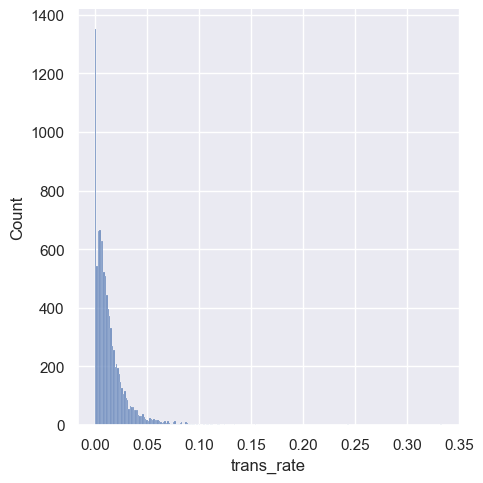

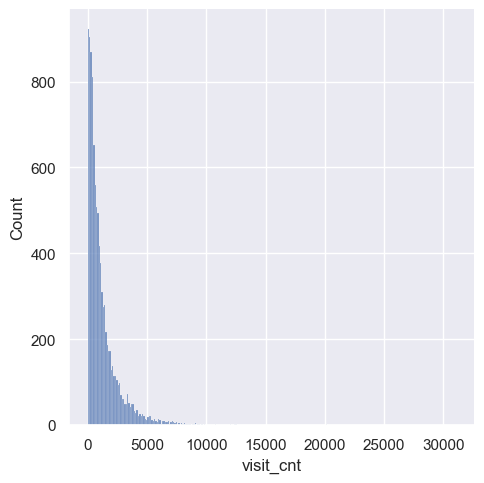

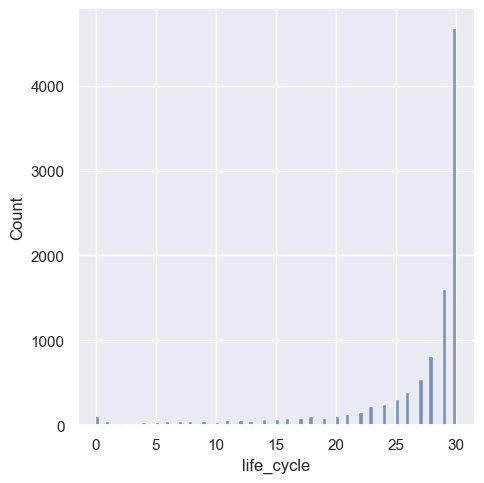

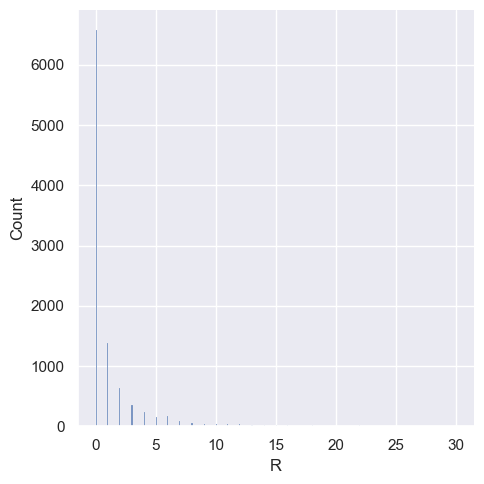

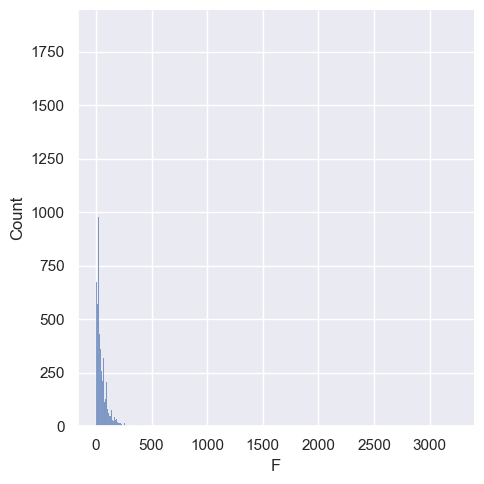

In [13]:
sns.displot(user_feat["trans_rate"])
sns.displot(user_feat["visit_cnt"])
sns.displot(user_feat["life_cycle"])
sns.displot(user_feat["R"])
sns.displot(user_feat["F"])

## Z-score标准化(visit_cnt和trans_rate)

In [43]:
# 导入StandardScaler用于特征标准化
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
# 创建StandardScaler对象
scaler = StandardScaler()

# 对trans_rate进行Z-score标准化
features = user_feat["trans_rate"].array[:, np.newaxis]
user_feat["trans_rate"] = scaler.fit_transform(features)  

# 对visit_cnt进行Z-score标准化
features = user_feat["visit_cnt"].array[:, np.newaxis]  
user_feat["visit_cnt"] = scaler.fit_transform(features)

# # 计算life_cycle的中值
# life_cycle_median = user_feat["life_cycle"].median()
# # 转换为超过中值的比例 (0-1之间)
# user_feat["life_cycle"] = (user_feat["life_cycle"] > life_cycle_median).astype(float)

# # 对life_cycle进行Z-score标准化
# features = user_feat["life_cycle"].array[:, np.newaxis]
# user_feat["life_cycle"] = scaler.fit_transform(features)

# 使用Min-Max标准化,保持时间跨度信息
minmax_scaler = MinMaxScaler()
user_feat["life_cycle"] = minmax_scaler.fit_transform(
    user_feat["life_cycle"].array[:, np.newaxis]
)

# R和F使用MinMaxScaler
minmax_scaler = MinMaxScaler()
user_feat["R"] = minmax_scaler.fit_transform(user_feat["R"].array[:, np.newaxis])
user_feat["F"] = minmax_scaler.fit_transform(user_feat["F"].array[:, np.newaxis])

# R和F不需要标准化,保持原值
# user_feat["R"] = user_feat["R"] 
# user_feat["F"] = user_feat["F"]

# 对R和F进行Z-score标准化
# features = user_feat["R"].array[:, np.newaxis]
# user_feat["R"] = scaler.fit_transform(features)
# features = user_feat["F"].array[:, np.newaxis]
# user_feat["F"] = scaler.fit_transform(features)

user_feat.head(10)

,user_id,trans_rate,visit_cnt,life_cycle,R,F
0,4913,-0.597326,0.340245,1.000000,0.000000,0.007417
1,6118,-0.315337,-0.730622,0.966667,0.000000,0.001236
2,7528,0.761758,-0.666699,0.766667,0.133333,0.007417
3,7591,0.563345,-0.241647,1.000000,0.000000,0.025958
4,12645,0.861970,-0.631114,1.000000,0.000000,0.009889
5,45368,-0.787669,-0.784000,0.500000,0.466667,0.000000
6,54056,2.120905,-0.782682,0.633333,0.366667,0.002472
7,63348,-0.567498,-0.642316,0.766667,0.066667,0.001236
8,79824,0.295917,-0.370810,1.000000,0.000000,0.016069
9,88930,0.004754,0.249304,1.000000,0.000000,0.028430


#### life_cycle:
##### 1.直接转化为超过中值的比例:
优点：
- 简单直观,容易理解和解释
- 可以清晰地将用户分为长期用户和短期用户两类
- 不受异常值影响

缺点：
- 损失了大量细节信息
- 无法反映用户生命周期的具体长短差异
- 可能导致聚类效果不够精确(信息不足)
##### 2.Z-score标准化
优点:
- 保留了数据的分布特征
- 消除了量纲影响,可以更好地比较不同特征之间的相关关系  

缺点: 
- 对异常值敏感
- 标准化后可能出现负值，不利于解释时间特征
- 如果原始数据不服从正态分布，效果可能不理想
##### 3.1.MinMaxScaler (当前使用的方法):
优点:
- 可以将数据压缩到[0,1]区间,保持了数据的相对比例关系
- 不会改变数据的分布形状
- 保留了用户生命周期的时间跨度信息 

缺点:
- 对异常值比较敏感
- 如果数据中存在极端值，可能会压缩正常值的范围
##### 4.保持原值:
- R和F的数值范围差异较大,会导致在聚类时某个特征的权重过大,不利于KMeans算法的收敛

##### 5.结论:
- 用户生命周期是一个连续的特征,二值化会损失太多信息
- 在进行聚类时,保留更多的原始信息可以得到更细致和准确的用户画像
- 对于营销策略制定来说,更细致的用户生命周期划分更有价值,可以帮助企业更好地理解用户的行为习惯和需求,从而制定更精准的营销策略

#### R和F:
##### 1.MinMaxScaler (当前使用的方法):
- 将数据压缩到[0,1]区间,保持了数据的相对比例关系
- 对于R(最近购买时间)和F(购买频次)这类有明确范围的特征比较合适
- 不会改变数据的分布形状,保持了数据的相对关系
##### 2.保持原值:
- R和F的数值范围差异较大,会导致在聚类时某个特征的权重过大,不利于KMeans算法的收敛
- 可能导致聚类结果偏向数值较大的特征
##### 3.Z-score标准化:
- 对于有明确范围的R和F特征来说过于激进
- 可能会改变数据的原始分布特征
- 标准化后的负值不利于理解业务含义
##### 4.结论:
R和F都有明确的业务含义和取值范围,是可以直接进行聚类,但是其特征值较大,会导致所占权重过大,因此需要进行处理.在使用MinMaxScaler处理后保留了数据的相对关系,可以得到更准确的聚类结果,便于后续的分析和决策。
 

In [15]:
user_feat.isnull().sum()

user_id       0
trans_rate    0
visit_cnt     0
life_cycle    0
R             0
F             0
dtype: int64

In [16]:
user_feat.dtypes

user_id         int64
trans_rate    float64
visit_cnt     float64
life_cycle    float64
R             float64
F             float64
dtype: object

## 相关系数

In [17]:
user_feat.drop(columns='user_id').corr()

,trans_rate,visit_cnt,life_cycle,R,F
trans_rate,1.000000,-0.198457,-0.145919,0.080240,0.229570
visit_cnt,-0.198457,1.000000,0.298372,-0.227698,0.463333
life_cycle,-0.145919,0.298372,1.000000,-0.660145,0.217557
R,0.080240,-0.227698,-0.660145,1.000000,-0.169720
F,0.229570,0.463333,0.217557,-0.169720,1.000000


<Axes: >

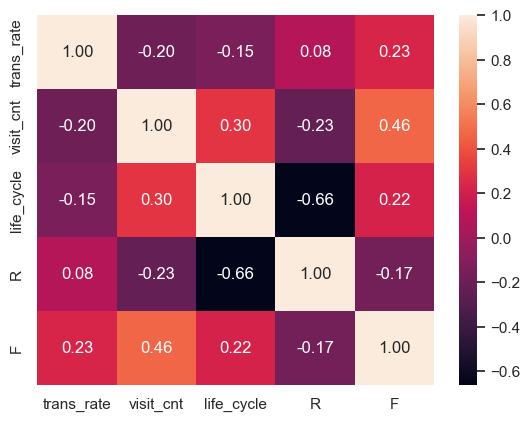

In [18]:
sns.heatmap(user_feat.drop(columns='user_id').corr(), annot=True, fmt='.2f')

1.trans_rate与其他特征相关性都不高,属于独立特征,应选择;   
2.visit_cnt与F相关性最高,达0.46,但这两个特征类型不同,visit_cnt表示使用频数,F表示购买频数,业务意义不同,所以也应选择这两个特征;   
3.life_cycle与R相关性达-0.66,过高,表明这两个特征包含相似信息,只选取其中一个特征。这里我们选择life_cycle,它表示用户存活时间,对用户分类更有意义;   
4.综上,我们选择四个特征:trans_rate, visit_cnt,life_cycle和F。   

# K-Means

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 选择特征
X = user_feat[["trans_rate", "visit_cnt", "life_cycle", "F"]]

# 尝试不同的K值
ks = range(2, 11)
labels_list = []


for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=1502).fit(X)
    # 计算质数分解后的聚类。 将结果与X中的簇名称一一对应的记忆化。 计算silhouette度。 这个度量单位是“距离”的近似值。
    labels = kmeans.labels_
    labels_list.append(labels)
    centroids = kmeans.cluster_centers_

## 模型评估

### silhouette Coefficient 轮廓系数  
<p align="center">silhouette_score=(b−a)/max(a,b)</p>   

值范围为[-1, 1],越大越好,代表样本的聚类效果越好

[np.float64(0.5134430352093514),
 np.float64(0.5549514548404554),
 np.float64(0.43140494365033194),
 np.float64(0.4488282699914608),
 np.float64(0.4344925630359419),
 np.float64(0.4284660139467207),
 np.float64(0.3837055163353763),
 np.float64(0.3872515588885525),
 np.float64(0.3501827409350116)]

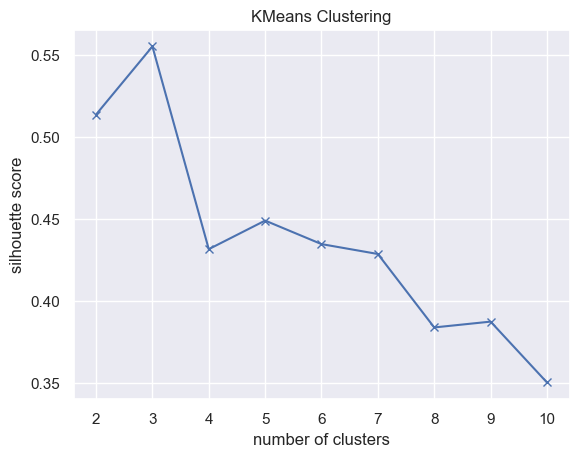

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

scores = [silhouette_score(X, labels, metric="euclidean") for labels in labels_list] # 计算silhouette度。

plt.plot(ks,scores,'bx-')
plt.xlabel('number of clusters')
plt.ylabel('silhouette score')
plt.title('KMeans Clustering') 

scores

### CH指数
<p align="center"> CH = (SSB/(k-1))/(SSW/(n-k)) </p>
CH指数通过计算SSB/SSW的比值,来评价聚类内部的密度相对于聚类间的密度,CH指数值越大,聚类效果越好。

[np.float64(3930.3139130924374),
 np.float64(6354.902443734721),
 np.float64(6202.001235112342),
 np.float64(6823.067418457767),
 np.float64(7202.514426642011),
 np.float64(7410.843898604632),
 np.float64(7610.642800949926),
 np.float64(8081.2801969),
 np.float64(8149.14637289245)]

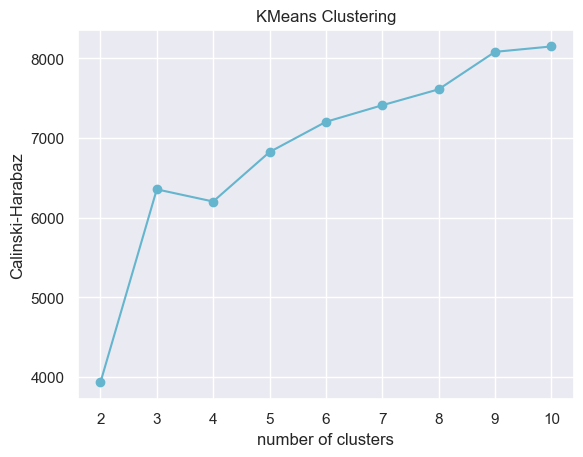

In [21]:
%matplotlib inline
from sklearn.metrics import calinski_harabasz_score
# calinski_harabasz_score函数用于计算Calinski-Harabasz度量。 参数y_true

scores = [calinski_harabasz_score(X, labels) for labels in labels_list]

plt.plot(ks,scores,'co-')
plt.xlabel('number of clusters')
plt.ylabel('Calinski-Harabaz')
plt.title('KMeans Clustering')
scores

### DB指数
<p align="center"> DB = (1/k)*sum(max(j≠i)(σi+σj)/dij)</p>
DB指数通过计算每个聚类内离散程度与其最邻近聚类间中心距离之比,来评价聚类内部的密集程度与聚类间的分离程度。所以,DB指数值越小越好。

[np.float64(0.8252804880811615),
 np.float64(0.6876266906365739),
 np.float64(0.7581419293762854),
 np.float64(0.7078026049411973),
 np.float64(0.6842805108866484),
 np.float64(0.6734526799529752),
 np.float64(0.7144269101201378),
 np.float64(0.6679688718962227),
 np.float64(0.7234657216309077)]

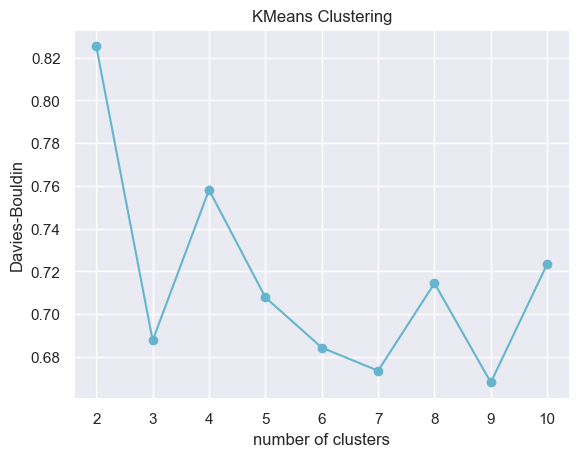

In [22]:
%matplotlib inline
from sklearn.metrics import davies_bouldin_score
 #davies_bouldin_score函数用于计算二次型的davies_bouldin度量。 参数y_true和y_pred将被分类。 返回davies_bouldin度量的值。 如果没有有效的分数，则返回最大值。 可以使用“近似”度量指数或单位。

scores = [davies_bouldin_score(X, labels) for labels in labels_list]

plt.plot(ks,scores,'co-')
plt.xlabel('number of clusters')
plt.ylabel('Davies-Bouldin')
plt.title('KMeans Clustering')

scores

# 结论

In [35]:
kmeans = KMeans(3, random_state=1657).fit(X)

labels = kmeans.labels_
centers = kmeans.cluster_centers_

user_feat["cluster"] = labels

user_feat

,user_id,trans_rate,visit_cnt,life_cycle,R,F,cluster
0,4913,-0.597326,0.340245,1.000000,0.000000,0.007417,1
1,6118,-0.315337,-0.730622,0.966667,0.000000,0.001236,1
2,7528,0.761758,-0.666699,0.766667,0.133333,0.007417,1
3,7591,0.563345,-0.241647,1.000000,0.000000,0.025958,1
4,12645,0.861970,-0.631114,1.000000,0.000000,0.009889,1
...,...,...,...,...,...,...,...
9995,142376113,-0.616045,-0.595528,0.833333,0.000000,0.001236,1
9996,142412247,1.191897,-0.586961,0.966667,0.033333,0.014833,2
9997,142430177,-0.601096,0.168248,1.000000,0.000000,0.006180,1
9998,142450275,-0.463499,3.685964,1.000000,0.000000,0.049444,0


,cluster,size
0,0,1171
1,1,7898
2,2,931


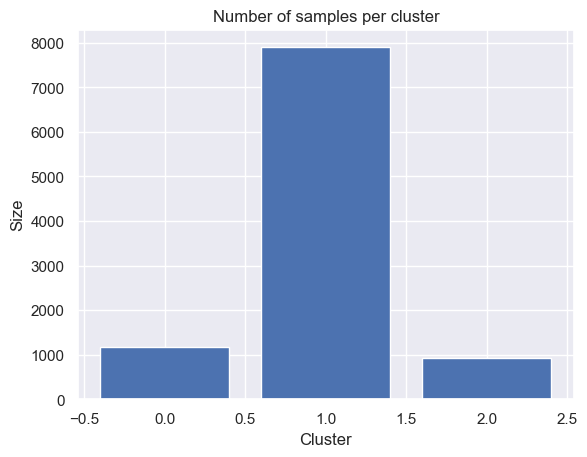

In [36]:
%matplotlib inline

cluster_size = user_feat.groupby("cluster").size().reset_index(name="size")

plt.bar(cluster_size['cluster'],cluster_size['size'])
plt.xlabel('Cluster')
plt.ylabel('Size')
plt.title('Number of samples per cluster')

cluster_size

In [37]:
user_feat.drop(columns="user_id").groupby(by="cluster").agg(["mean", "var"]).astype("object")

trans_rate           visit_cnt           life_cycle            \
              mean       var      mean       var       mean       var   
cluster                                                                 
0        -0.400206  0.125274  2.106165  2.128506   0.988557  0.002277   
1        -0.210663  0.217186 -0.245841  0.184445   0.892834  0.036785   
2         2.290502  2.920276 -0.563548   0.09204   0.794844    0.0721   

                R                   F            
             mean       var      mean       var  
cluster                                          
0        0.004042  0.000322  0.036704  0.002409  
1        0.043475   0.01136  0.010758  0.000151  
2        0.081131  0.021427  0.022169  0.000852

1.3个类别的数量划分较为均衡,最大类有7898个用户,最小类有931个用户,符合预期。  
2.从各类的特征均值和方差来看:  
3.类别0:trans_raye的均值较低(-0.40),visit_cnt和life_cycle均值较高,R的均值和方差也较小,F方差也较大(0.0024),似乎是访问频繁但购买目标不明确、消费次数变化较大的用户  
4.类别1:各特征的均值较低,变化较小,属于整体消费水平较低的用户群  
5.类别2:trans_rate均值较高(2.29),visit_cnt和life_cycle均值较低,且life_cycle方差较大(0.07),F的均值较小(0.11),似乎是相对不活跃且存活时间短、转化率高且使用时间跨度较大、购买目标明确的用户 
所以从统计特征来判断,3个类别比较明显对应不同的用户类型。  
7.从数据概览来看,绝大部分用户被分类到类别1,而较小类中用户ID更为密集,这也符合聚类结果的预期,即密集区域被划分为较小簇。

我们可以给4个类别起名如下:  
8.类别0:高频消费用户  
9.类别1:普通用户（低价值用户）  
10.类别2:高转化率用户  
综上,K-Means算法对这组用户数据的聚类效果较好,得到3个比较明显且有业务解释的用户分类。各类别的统计特征也与我们的理论推测相符,验证了分类的有效性。所以使用这3个类别及对应的用户类型,可以进一步针对不同类型的用户制定定制化的营销策略。并且也可以考虑对某一类别内的用户进一步细分,获得更加准确的用户分类。   

<Axes: >

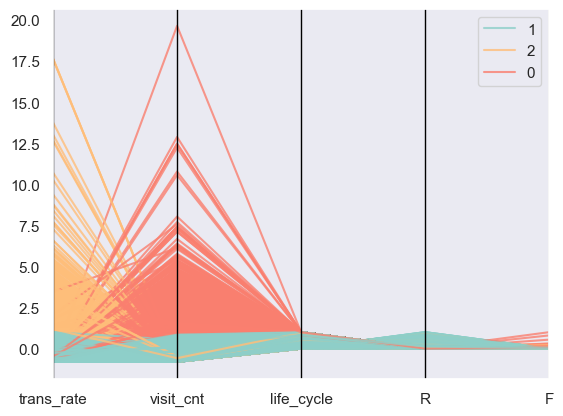

In [38]:
from pandas.plotting import parallel_coordinates

colors = ("#8ECFC9", "#FFBE7A", "#FA7F6F", "#82B0D2","#8856a7")
parallel_coordinates(
    user_feat.drop(columns="user_id"), "cluster", alpha=0.8, color=colors
)